In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print(f'pd=={pd.__version__}')
print(f'np=={np.__version__}')
print(f'sns=={sns.__version__}')

pd==2.2.0
np==1.26.4
sns==0.13.2


In [3]:
# read in train and test datasets
train_transaction = pd.read_csv('/Users/oskarwallberg/desktop/kaggle-datasets/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/Users/oskarwallberg/desktop/kaggle-datasets/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

test_transaction.columns = train_transaction.columns.drop(labels='isFraud') # ensure congruent columns

train_transaction.shape, test_transaction.shape

((590540, 393), (506691, 392))

In [4]:
fraud_transaction = train_transaction.loc[train_transaction['isFraud']==1]
valid_transaction = train_transaction.loc[train_transaction['isFraud']==0]
assert fraud_transaction.shape[0] + valid_transaction.shape[0] == train_transaction.shape[0]
fraud_transaction.shape, valid_transaction.shape

((20663, 393), (569877, 393))

In [5]:
FRAUD_RATE = fraud_transaction.shape[0] / train_transaction.shape[0]
FRAUD_RATE

0.03499000914417313

In [6]:
# Preprocessing steps
#   1. Encoding features as numerical
#   2. Filling NaNs
#   3. NOTE SKIP! FE, transforming, enriching, creating features
#   4. Selecting features (FS)
#   5. SMOTE and other over-/undersampling techniques
#   6. Outlier detection and filtering
# Done!

### Exploring Encoding Possibilities
---

In [7]:
# Numerical encoding
object_columns = train_transaction.select_dtypes(include=object).columns
binary_object_columns = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'] # M1-M3, M5-M9, encode as 0/1 for False/True
diverse_object_columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4'] # EDA and encode as best suited

for col in object_columns:
    print(col, train_transaction[col].nunique())

ProductCD 5
card4 4
card6 4
P_emaildomain 59
R_emaildomain 60
M1 2
M2 2
M3 2
M4 3
M5 2
M6 2
M7 2
M8 2
M9 2


In [8]:
# Diverse object columns EDA
def make_pivot(df:pd.DataFrame, index:str) -> pd.DataFrame:
    """..."""
    df[index] = df[index].fillna('NaN')
    df_pivot = df.pivot_table(index=index, columns='isFraud', aggfunc='size')
    df_pivot = df_pivot.fillna(0)
    df_pivot.columns = ['valid', 'fraud']
    df_pivot['count'] = df_pivot['valid'] + df_pivot['fraud']
    df_pivot[['valid_norm', 'fraud_norm']] = df_pivot[['valid', 'fraud']].div(other=df_pivot['count'], axis=0)
    df_pivot = df_pivot.sort_values(by='fraud_norm', ascending=False)
    return df_pivot
    


In [9]:
# Encoding ProductCD (product code feature)
pivot_prodcd = make_pivot(df=train_transaction, index='ProductCD')
pivot_prodcd

# NOTE Highest rate of fraud in descending order: C -> S -> H -> R -> W
# C : 11.7% : 68519
# S :  5.9% : 11628
# H :  4.8% : 33024
# R :  3.8% : 37699
# W :  2.0% : 439670

# Could encode as hierarchical with (C, S, H, R, W, NaN) -> (5, 4, 3, 2, 1, 0)

,valid,fraud,count,valid_norm,fraud_norm
ProductCD,,,,,
C,60511,8008,68519,0.883127,0.116873
S,10942,686,11628,0.941004,0.058996
H,31450,1574,33024,0.952338,0.047662
R,36273,1426,37699,0.962174,0.037826
W,430701,8969,439670,0.979601,0.020399


In [10]:
# Encoding card4 (payment card type)
pivot_card4 = make_pivot(df=train_transaction, index='card4')
pivot_card4

# NOTE Highest rate of fraud in descending order: discover -> visa -> mastercard -> american express
# discover	        0.077282
# visa	            0.034756
# mastercard        0.034331
# american express  0.028698

# Could encode as (discover, visa, mastercard, express, NaN) -> (4, 3, 2, 1, 0)

,valid,fraud,count,valid_norm,fraud_norm
card4,,,,,
discover,6137,514,6651,0.922718,0.077282
visa,371394,13373,384767,0.965244,0.034756
mastercard,182721,6496,189217,0.965669,0.034331
american express,8089,239,8328,0.971302,0.028698
NaN,1536,41,1577,0.974001,0.025999


In [11]:
# Encoding card6 ()
pivot_card6 = make_pivot(df=train_transaction, index='card6')
pivot_card6

# NOTE Create two columns : credit, debit - two flag columns 
# all 'debit or credit' will become 'debit'
# charge card is encoded as 0, 0


,valid,fraud,count,valid_norm,fraud_norm
card6,,,,,
credit,139036.0,9950.0,148986.0,0.933215,0.066785
NaN,1532.0,39.0,1571.0,0.975175,0.024825
debit,429264.0,10674.0,439938.0,0.975737,0.024263
charge card,15.0,0.0,15.0,1.000000,0.000000
debit or credit,30.0,0.0,30.0,1.000000,0.000000


In [12]:
# Encoding P_emaildomain ()
pivot_pdomain = make_pivot(df=train_transaction, index='P_emaildomain')
pivot_pdomain = pd.concat([pivot_pdomain, pd.DataFrame(data=[FRAUD_RATE], index=['scranton.edu'], columns=['fraud_norm'])])
pivot_pdomain.head(60)
# Ideas for how to encode:
#   1. Split domain strings into domain name, ending, landcode and potentially other types as separate features
#       - if ends with com / net 
#       - if ends witt 2 letter word (country code)
#       - first item is domain host
#   2. Order by fraud rate and partition into groups after some threshold values
#   3. Map each full domain string to its fraud rate - happen to match test data quite well

# Sketch of splitting domain strings...
# train_transaction.loc[train_transaction['P_emaildomain'].str.contains('.'), 'P_emaildomain'].str.split('.')
# df['domain_type'] = df['email'].str.extract(r'(.com|.org)$')


,valid,fraud,count,valid_norm,fraud_norm
protonmail.com,45.0,31.0,76.0,0.592105,0.407895
mail.com,453.0,106.0,559.0,0.810376,0.189624
outlook.es,381.0,57.0,438.0,0.869863,0.130137
aim.com,275.0,40.0,315.0,0.873016,0.126984
outlook.com,4614.0,482.0,5096.0,0.905416,0.094584
hotmail.es,285.0,20.0,305.0,0.934426,0.065574
live.com.mx,708.0,41.0,749.0,0.945260,0.054740
hotmail.com,42854.0,2396.0,45250.0,0.947050,0.052950
gmail.com,218412.0,9943.0,228355.0,0.956458,0.043542
yahoo.fr,138.0,5.0,143.0,0.965035,0.034965


In [13]:
# train P                    train R                   test P                     test R                   
# aim.com                315 aim.com                36 aim.com                153 aim.com                41
# anonymous.com        36998 anonymous.com       20529 anonymous.com        34064 anonymous.com       19115
# aol.com              28289 aol.com              3701 aol.com              24048 aol.com              3538
# att.net               4033 att.net               430 att.net               3614 att.net               440
# bellsouth.net         1909 bellsouth.net         422 bellsouth.net         1528 bellsouth.net         373
# cableone.net           159 cableone.net           27 cableone.net           152 cableone.net           19
# centurylink.net        205 centurylink.net        12 centurylink.net        181 centurylink.net        16
# cfl.rr.com             172 cfl.rr.com             37 cfl.rr.com             146 cfl.rr.com             20
# charter.net            816 charter.net           127 charter.net            627 charter.net           136
# comcast.net           7888 comcast.net          1812 comcast.net           6586 comcast.net          1701
# cox.net               1393 cox.net               459 cox.net               1264 cox.net               395
# earthlink.net          514 earthlink.net          79 earthlink.net          465 earthlink.net          91
# embarqmail.com         260 embarqmail.com         68 embarqmail.com         204 embarqmail.com         72
# frontier.com           280 frontier.com           52 frontier.com           314 frontier.com           58
# frontiernet.net        195 frontiernet.net        14 frontiernet.net        202 frontiernet.net        24
# gmail                  496 gmail                  95 gmail                  497 gmail                 101
# gmail.com           228355 gmail.com           57147 gmail.com           207448 gmail.com           61738
# gmx.de                 149 gmx.de                147 gmx.de                 149 gmx.de                150
# hotmail.co.uk          112 hotmail.co.uk         105 hotmail.co.uk          222 hotmail.co.uk         212
# hotmail.com          45250 hotmail.com         27509 hotmail.com          40399 hotmail.com         25657
# hotmail.de              43 hotmail.de             42 hotmail.de              87 hotmail.de             88
# hotmail.es             305 hotmail.es            292 hotmail.es             322 hotmail.es            303
# hotmail.fr             295 hotmail.fr            293 hotmail.fr             379 hotmail.fr            374
# icloud.com            6267 icloud.com           1398 icloud.com            6049 icloud.com           1422
# juno.com               322 juno.com               53 juno.com               252 juno.com               58
# live.com              3041 live.com              762 live.com              2679 live.com              682
# live.com.mx            749 live.com.mx           754 live.com.mx            721 live.com.mx           710
# live.fr                 56 live.fr                55 live.fr                 50 live.fr                50
# mac.com                436 mac.com               218 mac.com                426 mac.com               212
# mail.com               559 mail.com              122 mail.com               597 mail.com              219
# me.com                1522 me.com                556 me.com                1191 me.com                539
# msn.com               4092 msn.com               852 msn.com               3388 msn.com               846
# netzero.com            230 netzero.com            14 netzero.com            157 netzero.com            10
# netzero.net            196 netzero.net             9 netzero.net            123 netzero.net            10
# optonline.net         1011 optonline.net         187 optonline.net          926 optonline.net         163
# outlook.com           5096 outlook.com          2507 outlook.com           4838 outlook.com          2504
# outlook.es             438 outlook.es            433 outlook.es             425 outlook.es            420
# prodigy.net.mx         207 prodigy.net.mx        207 prodigy.net.mx          96 prodigy.net.mx         96
# protonmail.com          76 protonmail.com         41 protonmail.com          83 protonmail.com         34
# ptd.net                 68 ptd.net                27 ptd.net                 72 ptd.net                43
# q.com                  189 q.com                  25 q.com                  173 q.com                  20
# roadrunner.com         305 roadrunner.com         53 roadrunner.com         278 roadrunner.com         48
# rocketmail.com         664 rocketmail.com         69 rocketmail.com         441 rocketmail.com         57
# sbcglobal.net         2970 sbcglobal.net         552 sbcglobal.net         2797 sbcglobal.net         611
# sc.rr.com              164 sc.rr.com               8 sc.rr.com              113 sc.rr.com               6
#   * NOTE MISSING *         scranton.edu           63 scranton.edu             2 scranton.edu            6
# servicios-ta.com        35 servicios-ta.com       35 servicios-ta.com        45 servicios-ta.com       45
# suddenlink.net         175 suddenlink.net         25 suddenlink.net         148 suddenlink.net         30
# twc.com                230 twc.com                29 twc.com                209 twc.com                32
# verizon.net           2705 verizon.net           620 verizon.net           2306 verizon.net           582
# web.de                 240 web.de                237 web.de                 278 web.de                277
# windstream.net         305 windstream.net         47 windstream.net         247 windstream.net         57
# yahoo.co.jp             32 yahoo.co.jp            33 yahoo.co.jp             69 yahoo.co.jp            71
# yahoo.co.uk             49 yahoo.co.uk            39 yahoo.co.uk             54 yahoo.co.uk            43
# yahoo.com           100934 yahoo.com           11842 yahoo.com            81850 yahoo.com            9563
# yahoo.com.mx          1543 yahoo.com.mx         1508 yahoo.com.mx          1284 yahoo.com.mx         1235
# yahoo.de                74 yahoo.de               75 yahoo.de                63 yahoo.de               64
# yahoo.es               134 yahoo.es               57 yahoo.es               138 yahoo.es               67
# yahoo.fr               143 yahoo.fr              137 yahoo.fr               201 yahoo.fr              178
# ymail.com             2396 ymail.com             207 ymail.com             1679 ymail.com             198

# domain name -> fraud rate
# impute mean fraud rate for scranton...
# if unknown -> 0

In [14]:
# Encode R_emaildomain (receiver email domain)
pivot_rdomain = make_pivot(df=train_transaction, index='R_emaildomain')
pivot_rdomain

# Same method here as for P_emaildomain

,valid,fraud,count,valid_norm,fraud_norm
R_emaildomain,,,,,
protonmail.com,2.0,39.0,41.0,0.048780,0.951220
mail.com,76.0,46.0,122.0,0.622951,0.377049
netzero.net,7.0,2.0,9.0,0.777778,0.222222
outlook.com,2093.0,414.0,2507.0,0.834862,0.165138
outlook.es,376.0,57.0,433.0,0.868360,0.131640
...,...,...,...,...,...
centurylink.net,12.0,0.0,12.0,1.000000,0.000000
juno.com,53.0,0.0,53.0,1.000000,0.000000
cfl.rr.com,37.0,0.0,37.0,1.000000,0.000000


In [15]:
test_transaction['R_emaildomain'].value_counts().sort_index()

R_emaildomain
aim.com                41
anonymous.com       19115
aol.com              3538
att.net               440
bellsouth.net         373
cableone.net           19
centurylink.net        16
cfl.rr.com             20
charter.net           136
comcast.net          1701
cox.net               395
earthlink.net          91
embarqmail.com         72
frontier.com           58
frontiernet.net        24
gmail                 101
gmail.com           61738
gmx.de                150
hotmail.co.uk         212
hotmail.com         25657
hotmail.de             88
hotmail.es            303
hotmail.fr            374
icloud.com           1422
juno.com               58
live.com              682
live.com.mx           710
live.fr                50
mac.com               212
mail.com              219
me.com                539
msn.com               846
netzero.com            10
netzero.net            10
optonline.net         163
outlook.com          2504
outlook.es            420
prodigy.net.mx         9

In [16]:
# Encode M4 (match 4)
pivot_m4 = make_pivot(df=train_transaction, index='M4')
pivot_m4

# Hierarchical encoding (M2, M0, M1, NaN) -> (...rates...)
# Map each value to its fraud rate

,valid,fraud,count,valid_norm,fraud_norm
M4,,,,,
M2,53056,6809,59865,0.886261,0.113739
M0,189207,7198,196405,0.963351,0.036649
M1,51397,1429,52826,0.972949,0.027051
NaN,276217,5227,281444,0.981428,0.018572


### Encoding the Features to Numerical Values
---

In [17]:
train_transaction_pp = train_transaction.copy()
train_transaction_pp.shape

(590540, 393)

In [18]:
# Encode binary features T/F/NaN as 1/0/-1
train_transaction_pp[binary_object_columns] = train_transaction[binary_object_columns].map(lambda x: 1 if x=='T' else 0 if x=='F' else -1)
train_transaction_pp[binary_object_columns]

,M1,M2,M3,M5,M6,M7,M8,M9
TransactionID,,,,,,,,
2987000,1,1,1,0,1,-1,-1,-1
2987001,-1,-1,-1,1,1,-1,-1,-1
2987002,1,1,1,0,0,0,0,0
2987003,-1,-1,-1,1,0,-1,-1,-1
2987004,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
3577535,1,1,1,1,0,0,0,1
3577536,1,0,0,0,1,0,0,0
3577537,1,0,0,-1,1,-1,-1,-1


In [19]:
# map from index to series values - from product codes to fraud rates
train_transaction_pp['ProductCD'] = train_transaction['ProductCD'].map(pivot_prodcd['fraud_norm'])
train_transaction_pp['card4'] = train_transaction['card4'].map(pivot_card4['fraud_norm'])
train_transaction_pp['card6'] = train_transaction['card6'].map(pivot_card6['fraud_norm'])
train_transaction_pp['M4'] = train_transaction['M4'].map(pivot_m4['fraud_norm'])

# encode emaildomain features

# p_domain_lists = train_transaction['P_emaildomain'].fillna('NaN').str.split('.')

# NOTE EXCLUDE NOTE  p_country_code = p_domain_lists.transform(lambda l: l[-1] if len(l[-1])==2 else np.NaN) # NOTE Majority is NaN! Only 4% has country codes...
# p_email_host = p_domain_lists.transform(lambda l: l[0] if l[0]!='NaN' else np.NaN)
# p_email_tld = p_domain_lists.transform(lambda l: 'com' if 'com' in l else 'net' if 'net' in l else np.NaN) # TLD stands for 'top level domain'
# train_transaction_pp['P_email_host'] = p_email_host
# train_transaction_pp['P_email_tld'] = p_email_tld

# map domain names to fraud rate - impute for the one missing
train_transaction_pp['P_domain_fraud_rate'] = train_transaction['P_emaildomain'].map(pivot_pdomain['fraud_norm'])

# partition fraud rates into degree of risks
# <1%           low risk 0
# >=1% & <5% medium risk 1
# >=5%         high risk 2
# NaNs       medium risk 1
train_transaction_pp['P_domain_risk_group'] = train_transaction_pp['P_domain_fraud_rate'].transform(lambda x: 0 if x<0.01 else 1 if 0.01<=x<0.05 else 2 if 0.05<=x else np.NaN)

In [20]:
diverse_encoded_columns = ['ProductCD', 'card4', 'card6', 'P_domain_fraud_rate', 'P_domain_risk_group', 'M4']
train_transaction_pp[diverse_encoded_columns]

,ProductCD,card4,card6,P_domain_fraud_rate,P_domain_risk_group,M4
TransactionID,,,,,,
2987000,0.020399,0.077282,0.066785,0.029538,1,0.113739
2987001,0.020399,0.034331,0.066785,0.043542,1,0.036649
2987002,0.020399,0.034756,0.024263,0.094584,2,0.036649
2987003,0.020399,0.034331,0.024263,0.022757,1,0.036649
2987004,0.047662,0.034331,0.066785,0.043542,1,0.018572
...,...,...,...,...,...,...
3577535,0.020399,0.034756,0.024263,0.029538,1,0.036649
3577536,0.020399,0.034331,0.024263,0.043542,1,0.036649
3577537,0.020399,0.034331,0.024263,0.043542,1,0.018572


In [21]:
train_transaction_pp = train_transaction_pp.drop(columns=train_transaction_pp.select_dtypes(object).columns) # faster this way since fewer object column, 2 to 390-ish numerical
train_transaction_pp.select_dtypes(object).columns # should be no object columns left!

Index([], dtype='object')

In [22]:
# Preprocessing steps
#   1. Encoding features as numerical
#   2. Filling NaNs
#   3. NOTE SKIP! FE, transforming, enriching, creating features
#   4. Selecting features
#   5. SMOTE and other over-/undersampling techniques
#   6. Outlier detection and filtering
# Done!

### Handling NaNs
---

In [23]:
# This many columns contains some form of NaNs
train_transaction_pp.isna().any(axis=0).sum()

361

In [24]:
# Simple solution to impute all columns not containing -1 with -1 for NaNs
# NOTE lazy solution but a quick fix and can be iterated on further down the line
is_nan = train_transaction_pp.isna().any(axis=0)
is_neg = train_transaction_pp.lt(0).any(axis=0)
columns_nan_special = train_transaction_pp.loc[:, (is_nan & is_neg)].columns # the columns both containing NaNs to be patched and that already contains negative values, in need of a different solution
columns_nan_normal = train_transaction_pp.loc[:, (is_nan & ~is_neg)].columns
print(f'Normal imputing (-1): {columns_nan_normal.shape[0]}')
print(f'Special imputing (x): {columns_nan_special.shape[0]}')


Normal imputing (-1): 355
Special imputing (x): 6


In [25]:
train_transaction_pp[columns_nan_normal] = train_transaction_pp[columns_nan_normal].fillna(-1)
print(f'NaN cols remaining: {train_transaction_pp.isna().any(axis=0).sum()}') # remaining NaN columns requiring special handling

NaN cols remaining: 6


In [26]:
# Remarkably few negative values in each of the columns...
# XXX Are negative Timedeltas reasonable in this scenario or improper data?
train_transaction_pp[columns_nan_special].lt(0).sum(axis=0)

D4     15
D6      3
D11     7
D12     2
D14     3
D15    15
dtype: int64

In [27]:
# All 25th percentiles are at 0, is probably the most reasonable imputation besides the value -1
train_transaction_pp[columns_nan_special].describe().T

,count,mean,std,min,25%,50%,75%,max
D4,421618.0,140.002441,191.096774,-122.0,0.0,26.0,253.0,869.0
D6,73187.0,69.805717,143.669253,-83.0,0.0,0.0,40.0,873.0
D11,311253.0,146.621465,186.042622,-53.0,0.0,43.0,274.0,670.0
D12,64717.0,54.037533,124.274558,-83.0,0.0,0.0,13.0,648.0
D14,62187.0,57.724444,136.312450,-193.0,0.0,0.0,2.0,878.0
D15,501427.0,163.744579,202.726660,-83.0,0.0,52.0,314.0,879.0


In [28]:
train_transaction_pp[list(columns_nan_special)+['isFraud']].loc[train_transaction_pp[columns_nan_special].lt(0).any(axis=1)]

,D4,D6,D11,D12,D14,D15,isFraud
TransactionID,,,,,,,
2989947,-15.0,NaN,-15.0,NaN,NaN,-15.0,0
2990034,NaN,NaN,29.0,NaN,NaN,-30.0,0
2990814,NaN,NaN,-33.0,NaN,NaN,363.0,0
2991085,NaN,NaN,NaN,NaN,-193.0,NaN,0
2991097,NaN,NaN,NaN,NaN,-193.0,NaN,0
2991210,-90.0,NaN,298.0,NaN,NaN,298.0,0
2991932,NaN,NaN,-13.0,NaN,NaN,-13.0,0
2992264,-122.0,NaN,NaN,NaN,NaN,NaN,0
2992501,-83.0,-83.0,NaN,-83.0,-83.0,-83.0,0


In [29]:
# Considering the still substantial number of values, the few negative may as well be treated as outliers. Well wait with this claim for now and see later...
train_transaction_pp[columns_nan_special].info()

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 2987000 to 3577539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   D4      421618 non-null  float64
 1   D6      73187 non-null   float64
 2   D11     311253 non-null  float64
 3   D12     64717 non-null   float64
 4   D14     62187 non-null   float64
 5   D15     501427 non-null  float64
dtypes: float64(6)
memory usage: 31.5 MB


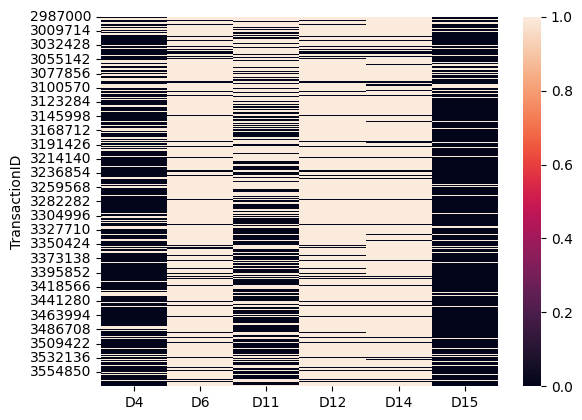

In [30]:
sns.heatmap(data=train_transaction_pp[columns_nan_special].isna(), cbar=True)
plt.show()

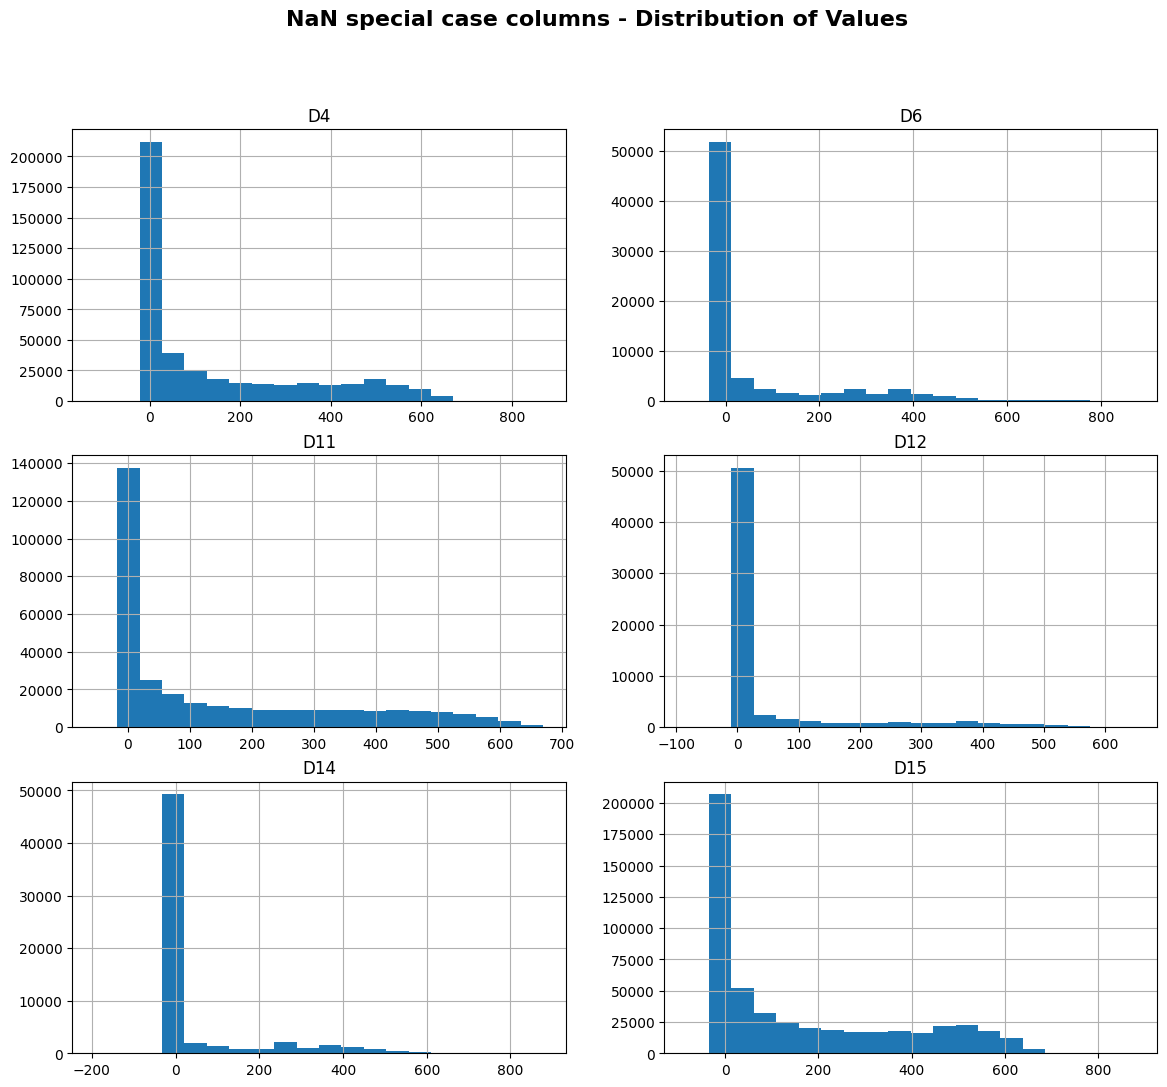

In [31]:
fig = plt.figure(figsize=(14, 12))
fig.suptitle("NaN special case columns - Distribution of Values", fontweight="bold", fontsize=16)
gs = plt.GridSpec(nrows=3, ncols=2)
for i, ax_loc in enumerate(gs):
    col = columns_nan_special[i]
    ax = fig.add_subplot(ax_loc)
    ax.set_title(col)
    train_transaction_pp[col].hist(bins=20)
plt.show()

In [32]:
train_transaction_pp[columns_nan_special] = train_transaction_pp[columns_nan_special].fillna(-1) # -1 still seems to be the best impute value still (maybe 0 / the mode)
print(f'NaN cols remaining: {train_transaction_pp.isna().any(axis=0).sum()}')

NaN cols remaining: 0


In [33]:
# Seems OK!
train_transaction_pp.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 2987000 to 3577539
Data columns (total 393 columns):
 #    Column               Non-Null Count   Dtype  
---   ------               --------------   -----  
 0    isFraud              590540 non-null  int64  
 1    TransactionDT        590540 non-null  int64  
 2    TransactionAmt       590540 non-null  float64
 3    ProductCD            590540 non-null  float64
 4    card1                590540 non-null  int64  
 5    card2                590540 non-null  float64
 6    card3                590540 non-null  float64
 7    card4                590540 non-null  float64
 8    card5                590540 non-null  float64
 9    card6                590540 non-null  float64
 10   addr1                590540 non-null  float64
 11   addr2                590540 non-null  float64
 12   dist1                590540 non-null  float64
 13   dist2                590540 non-null  float64
 14   C1                   590540 non-null  float64
 1

### Feature Engineering, SKIP For now!
---

In [34]:
# to be implemented...
# NOTE for future_
#   : add DXn columns as shown by winning competitors - perhaps those versions are more interpretable for the model??

### Feature Selection
---

#### Correlation Analysis

In [35]:
# Correlation Matricies
columns_vesta = np.array([f"V{i}" for i in range(1, 340)])
columns_non_vesta = train_transaction_pp.columns.drop(labels=columns_vesta)

In [36]:
def plot_corr_heatmap(df:pd.DataFrame, annot=False, figsize=(12, 10)):
    """Create and plot heatmap of feature correlation matrix"""
    corr = df.corr()
    
    mask = np.zeros_like(corr, dtype=bool) # not masking any at the moment, all masking is false
    triu_index = np.triu_indices_from(mask) # argument to mask upper triangle of correlation matrix, redundant otherwise
    mask[triu_index] = True

    fig = plt.figure(figsize=figsize)
    sns.heatmap(data=corr, mask=mask, vmin=-1, center=0, vmax=1, cmap="coolwarm", cbar=True, annot=annot, fmt=".2g")
    plt.show()

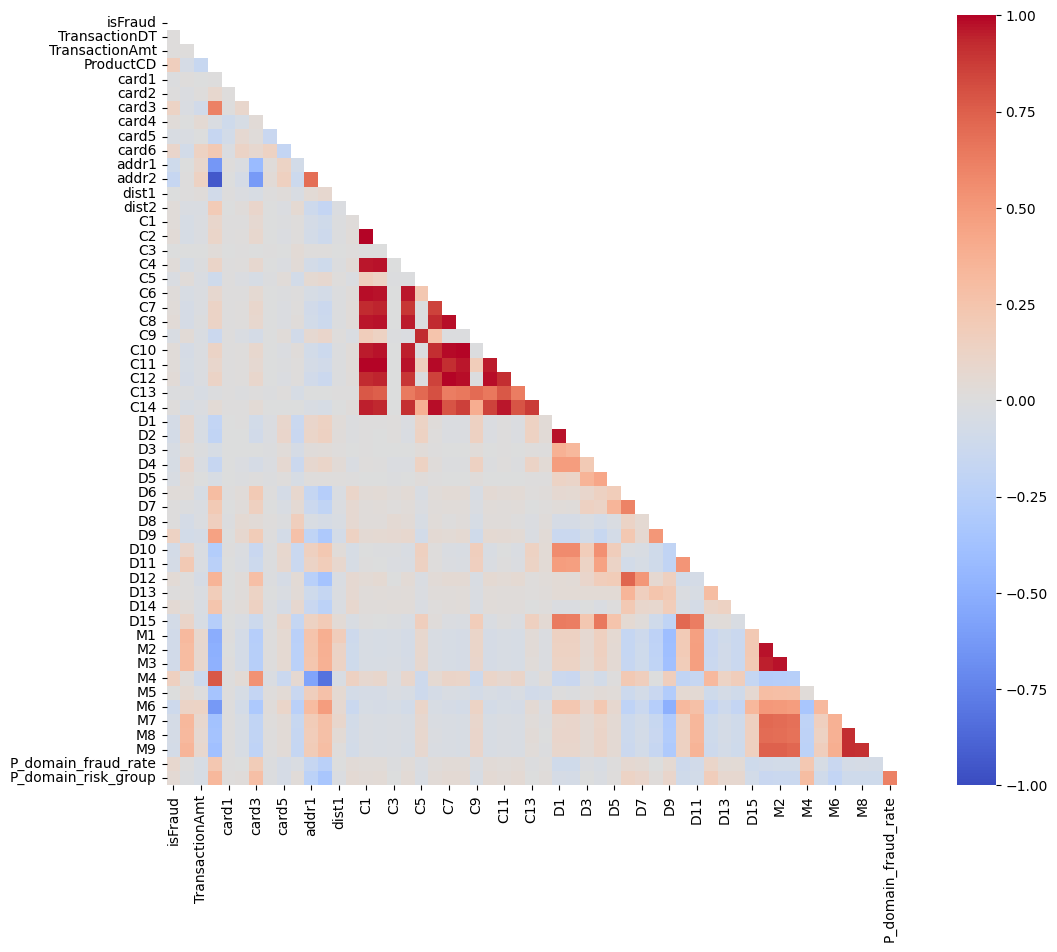

In [37]:
plot_corr_heatmap(df=train_transaction_pp[columns_non_vesta])
# From this investivation, the suspect column families are:
#   : count columns (CX)
#   : match columns (MX)
# We view them separately, the reason being that viewing all column as once becomes unreadable

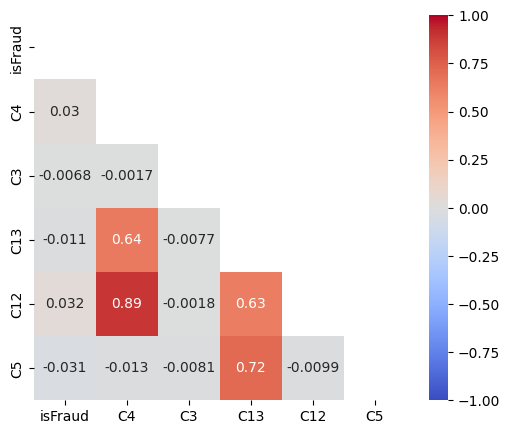

In [38]:
columns_cx_drop = ["C1", "C2", "C6", "C7", "C8", "C9", "C10", "C11", "C14"] # candidates to drop, no correlation over 90%
columns_cx = [f"C{i}" for i in range(1, 15)]
columns_cx_keep = list(set(columns_cx) - set(columns_cx_drop))
plot_corr_heatmap(df=train_transaction_pp[["isFraud"]+columns_cx_keep], annot=True, figsize=(6, 5))

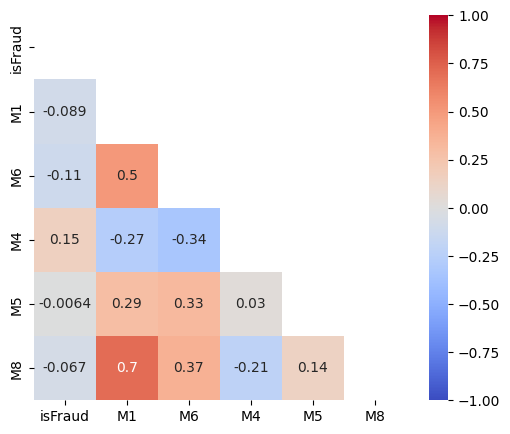

In [39]:
columns_mx_drop = ["M2", "M3", "M7", "M9"] # cadidates to drop, no correlation over 90%
columns_mx = [f"M{i}" for i in range(1, 10)]
columns_mx_keep = list(set(columns_mx) - set(columns_mx_drop))
plot_corr_heatmap(df=train_transaction_pp[["isFraud"]+columns_mx_keep], annot=True, figsize=(6, 5))

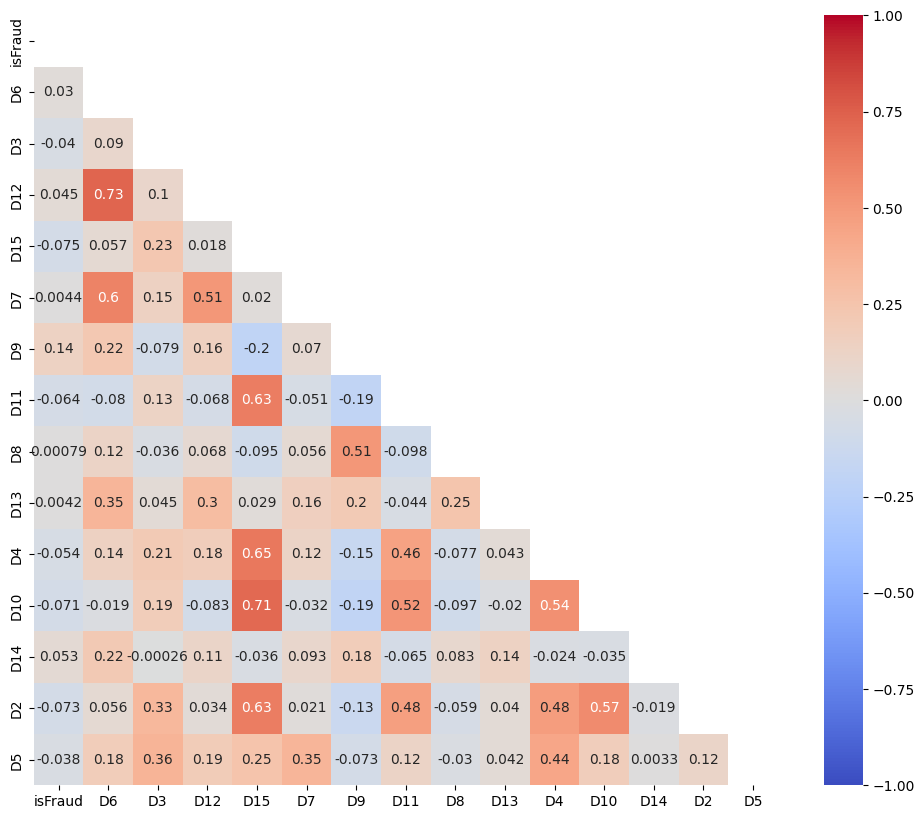

In [40]:
# D1 and D2 strongly correlated, drop D1 since weaker correlation with isFraud
train_transaction_pp[["isFraud", "D1", "D2"]].corr()
columns_dx_drop = ["D1"]
columns_dx = [f"D{i}" for i in range(1, 16)]
columns_dx_keep = list(set(columns_dx)-set(columns_dx_drop))
plot_corr_heatmap(df=train_transaction_pp[["isFraud"]+columns_dx_keep], annot=True, figsize=(12, 10))

In [41]:
# plot_corr_heatmap(df=train_transaction_pp[["isFraud"]+list(columns_v100)], annot=True, figsize=(18, 16))
corr_vesta = train_transaction_pp[['isFraud']+list(columns_vesta)].corr()
corr_vesta.shape

(340, 340)

In [42]:
# might keep, many corr: 
# 'V173', 'V188'!, 'V191', 'V194', 'V195', 'V197', 'V198'
# 'V223', 'V240', 'V241', 'V242'!, 'V244'!, 'V247', 'V248', 'V249', 'V250', 'V251', 'V252'

# might keep, some corr:
# ... only above 0.2
# 'V170', 'V171', 'V176', 'V188', 'V189', 'V190', 'V199', 'V200', 'V201',
# 'V228', 'V230', 'V242', 'V243', 'V244', 'V246', 'V257', 'V258', 

# might keep, few corr:
# 'V44', 'V45', 'V111', 'V123', 'V125', 'V169', 'V170', 'V171', 'V175', 'V181', 'V185', 'V187',
# 'V220', 'V222', 'V229', 'V235', 'V238', 'V239', 'V258'!!, 'V282', 'V283', 'V303', 'V304',


# columns_corr_drop_axis1 = corr_vesta.gt(0.9).sum(axis=1) + corr_vesta.lt(-0.9).sum(axis=1) 
num_high_corr_by_column = corr_vesta.gt(0.9).sum(axis=0) + corr_vesta.lt(-0.9).sum(axis=0) - 1 # minus 1 since all columns have 100% correlation with itself

# Quick filter for features to drop
# if less than 0.07 correlation with isFraud and more than 3 highly correlated features -> Arrata!
feature_corr_threshold = num_high_corr_by_column.gt(3)  # multicollinearity
isfraud_corr_threshold = corr_vesta['isFraud'].lt(0.07) # to little impact

vesta_drop_mask = feature_corr_threshold & isfraud_corr_threshold

columns_vx_drop = num_high_corr_by_column.loc[vesta_drop_mask].index.to_list()
columns_vx_keep = num_high_corr_by_column.loc[~vesta_drop_mask].index.to_list()

len(columns_vx_drop), len(columns_vx_keep)

(105, 235)

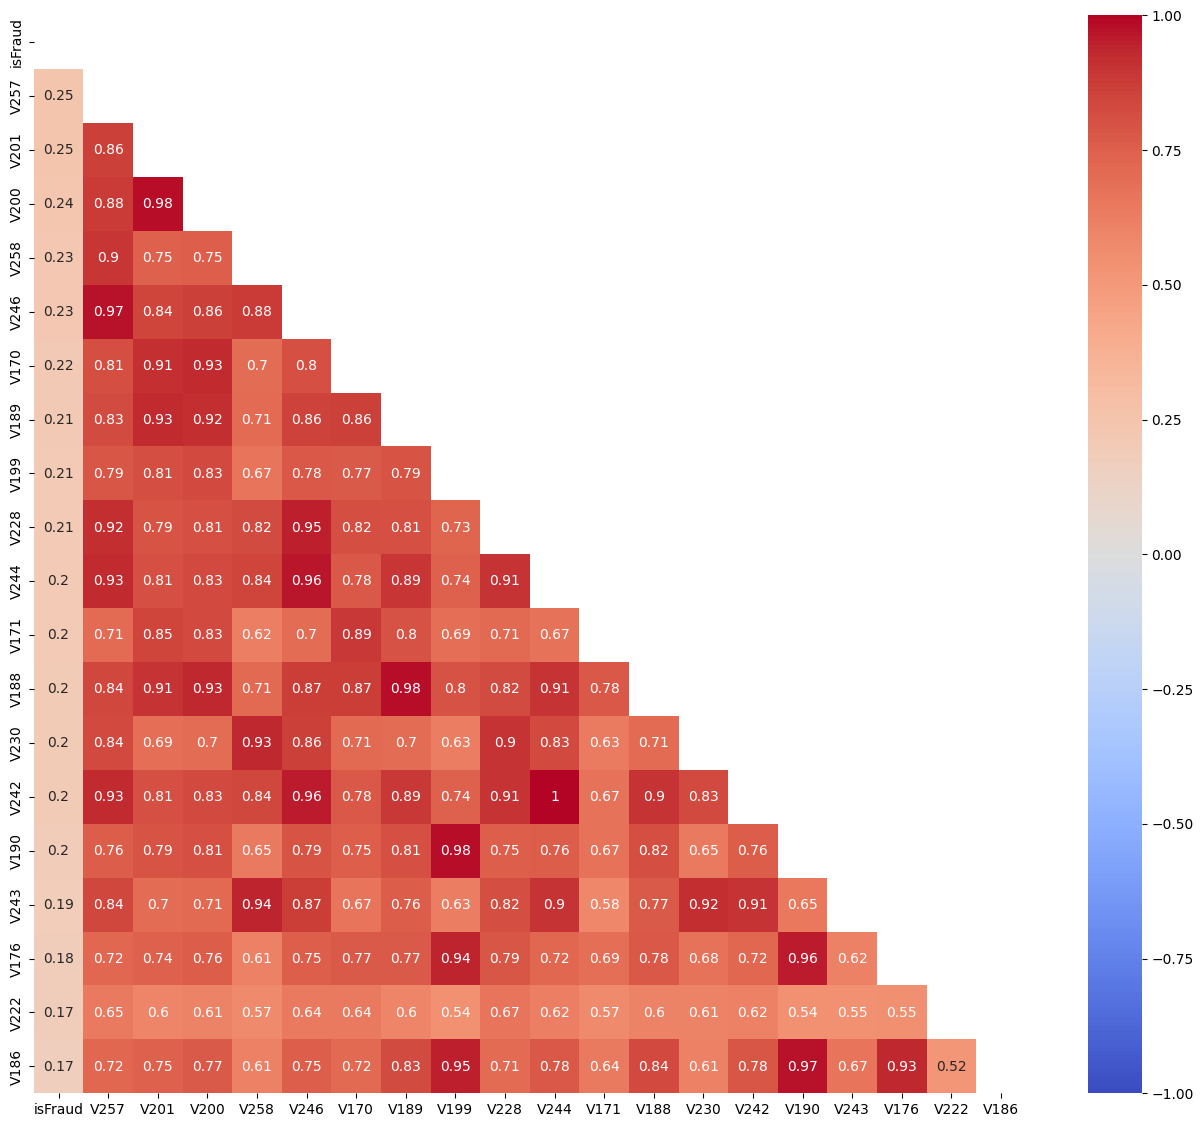

In [43]:
# Top 20 Vesta features correlated with isFraud
plot_corr_heatmap(df=train_transaction_pp[corr_vesta['isFraud'].sort_values(ascending=False)[:20].index], annot=True, figsize=(16, 14))


In [44]:
# The number of columns to drop from the correlation analysis. 
columns_corr_drop = columns_cx_drop+columns_mx_drop+columns_dx_drop+columns_vx_drop
len(columns_corr_drop)

119

In [45]:
# Name explanation: preprocessed (pp) train transaction data after 1st round of feature selection (fs1)
train_transaction_pp_fs1 = train_transaction_pp.drop(columns=columns_corr_drop).copy()
train_transaction_pp_fs1.shape

(590540, 274)

In [46]:
# Dataset is now 1.2 GB instead of 1.7 GB!
train_transaction_pp_fs1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 2987000 to 3577539
Columns: 274 entries, isFraud to P_domain_risk_group
dtypes: float64(266), int64(8)
memory usage: 1.2 GB


#### Using LR w. Lasso (L1) regularisation for Feature Selection
* LR is practical for binary labels (isFraud)

In [66]:
logreg = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=1,
    max_iter=100,
    verbose=True,
    n_jobs=-1,
    class_weight={0: 1, 1:4},
    # Cs=2,           # inverse regularisation strengths, logarithmic range of 10 values
    # cv=3,           # CV folds
    # penalty="l1",   # Lasso (L1) regularisation
    # solver="saga",  # better for large dataset, liblinear for small datasets
    # max_iter=100,   # adjust for strong regularisation (especially for saga solver)
    # verbose=True,
    # n_jobs=-1,
)

logreg

LogisticRegression(C=1, class_weight={0: 1, 1: 4}, n_jobs=-1, penalty='l1',
                   solver='saga', verbose=True)

In [67]:
sc = StandardScaler(with_mean=True, with_std=True)

sc

StandardScaler()

In [64]:
y = train_transaction_pp_fs1['isFraud'].copy()
X = train_transaction_pp_fs1.drop(columns='isFraud').copy()

X_sc = pd.DataFrame(
    index=X.index,
    columns=X.columns,
    data=sc.fit_transform(X=X),
)

X_sc.shape, y.shape

((590540, 273), (590540,))

In [68]:
# logreg.fit(X_sc, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29217990
Epoch 3, change: 0.18788865
Epoch 4, change: 0.14602086
Epoch 5, change: 0.12109114
Epoch 6, change: 0.10292197
Epoch 7, change: 0.09145452
Epoch 8, change: 0.08243167
Epoch 9, change: 0.07501567
Epoch 10, change: 0.06881059
Epoch 11, change: 0.06348244
Epoch 12, change: 0.05784877
Epoch 13, change: 0.05339872
Epoch 14, change: 0.04942537
Epoch 15, change: 0.04594522
Epoch 16, change: 0.04274419
Epoch 17, change: 0.04010408
Epoch 18, change: 0.03754384
Epoch 19, change: 0.03528201
Epoch 20, change: 0.03339454
Epoch 21, change: 0.03152386
Epoch 22, change: 0.02981327
Epoch 23, change: 0.02830191
Epoch 24, change: 0.02688130
Epoch 25, change: 0.02560347
Epoch 26, change: 0.02435999
Epoch 27, change: 0.02319214
Epoch 28, change: 0.02217998
Epoch 29, change: 0.02122551
Epoch 30, change: 0.02025411
Epoch 31, change: 0.01941250
Epoch 32, change: 0.01860537
Epoch 33, change: 0.01783271
Epoch 34, change: 0.01710497
Epoch 35, change: 0.016

/Users/oskarwallberg/Desktop/IEEE-CIS-Fraud-Detection/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, class_weight={0: 1, 1: 4}, n_jobs=-1, penalty='l1',
                   solver='saga', verbose=True)

In [73]:
# feature_importance = pd.Series(data=logreg.coef_[0], index=X_sc.columns).abs().sort_values(ascending=False)
# for (index, importance) in feature_importance.items():
#     print(index, importance)

card6 0.23391241534050192
M5 0.20931464842999536
V45 0.19355069449542903
D8 0.1845148699830497
P_domain_fraud_rate 0.17123913608111577
V147 0.16765544573968777
V258 0.16555910845243832
V223 0.15533815413896473
V201 0.15506336415504457
V241 0.1538043088134148
V240 0.15374240240460155
V283 0.15147630026911413
V87 0.1497516463274453
V257 0.14936163797183497
TransactionAmt 0.1476184030059973
V261 0.1386897253409982
V200 0.1315465600953942
V44 0.12540782117698596
V328 0.12504188572877736
card3 0.12454921273245333
V35 0.12369463403376357
V173 0.12333732605546119
D9 0.1194638841425478
V199 0.11681325701978554
TransactionDT 0.11569543773273955
V172 0.11183554323960826
V55 0.11159852085241811
V13 0.11026500084730147
P_domain_risk_group 0.10876348386556915
V189 0.10443276076963011
M4 0.1043456142440642
V246 0.10364432114152525
V48 0.10317439872957834
D3 0.10130554916761848
V139 0.1001157014068829
V50 0.09995879590046117
V152 0.09847480216887837
V70 0.09509545709022757
ProductCD 0.091708662565113